<a href="https://colab.research.google.com/github/Maks3174/Phy/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

Дані про розпад протонів

[посилання](https://www.kaggle.com/datasets/fedesoriano/multijet-primary-dataset)

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/MultiJetRun2010B.csv')

df = df[df['nBJets'] != 2]

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані погано збалансовані

In [3]:
df['nBJets'].value_counts()

,count
nBJets,
0,20615
1,1056


In [4]:
df.head()

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,0.082072,0.0,0.000002,0.077191,0.041860,0.044618,0.342725,0.531326,0.480732,0.055588,0.696681,0.457241,0.440224,0.061659,0.043047,0.0,0
1,0.082072,0.0,0.000006,0.052182,0.055190,0.018690,0.493614,0.585784,0.491979,0.017684,0.567978,0.430552,0.474613,0.025133,0.034687,0.0,0
2,0.082072,0.0,0.000015,0.154156,0.035263,0.101251,0.540018,0.671386,0.470196,0.273968,0.533484,0.338381,0.325311,0.165718,0.059381,0.2,0
3,0.082072,0.0,0.000048,0.106599,0.123328,0.063472,0.306290,0.523352,0.483465,0.039306,0.713922,0.422854,0.493248,0.101707,0.108566,0.0,0
4,0.082072,0.0,0.000063,0.072599,0.024611,0.383563,0.508826,0.564737,0.292545,0.224039,0.550834,0.433906,0.361549,0.110721,0.018941,0.2,0


Потрібно на основі інформації про розпад спрогнозувати наявність високоенергетичного випромінювання `nBJets`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [5]:
class JetDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.drop('nBJets', axis=1).values
        self.labels = dataframe['nBJets'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(JetDataset(df), [train_size, test_size])

# Завдання 2
Створіть DataLoader

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Завдання 3
Створіть нейромережу

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(len(columns), 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def plot_learning_curve(losses):
    plt.plot(losses)
    plt.xlabel('Епоха')
    plt.ylabel('Втрати')
    plt.title('Графік втрат під час навчання')
    plt.show()

# Завдання 5
Натренуйте нейромережу.

Epoch [1/20], Loss: 0.2124
Epoch [2/20], Loss: 0.1957
Epoch [3/20], Loss: 0.1956
Epoch [4/20], Loss: 0.1954
Epoch [5/20], Loss: 0.1952
Epoch [6/20], Loss: 0.1953
Epoch [7/20], Loss: 0.1947
Epoch [8/20], Loss: 0.1952
Epoch [9/20], Loss: 0.1944
Epoch [10/20], Loss: 0.1941
Epoch [11/20], Loss: 0.1942
Epoch [12/20], Loss: 0.1943
Epoch [13/20], Loss: 0.1943
Epoch [14/20], Loss: 0.1943
Epoch [15/20], Loss: 0.1943
Epoch [16/20], Loss: 0.1940
Epoch [17/20], Loss: 0.1941
Epoch [18/20], Loss: 0.1942
Epoch [19/20], Loss: 0.1940
Epoch [20/20], Loss: 0.1941


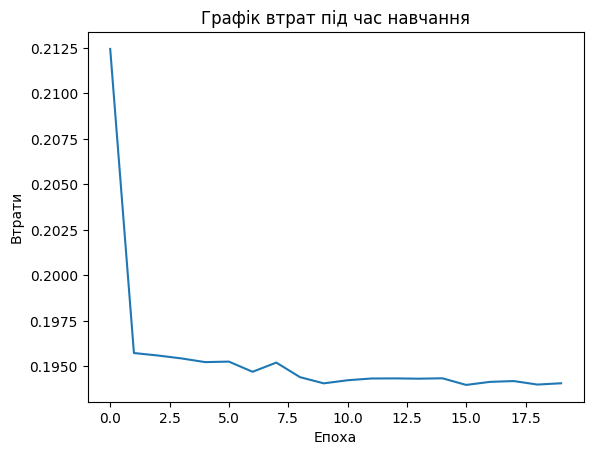

In [9]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

plot_learning_curve(train_losses)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [10]:
torch.save(model.state_dict(), 'jet_model.pth')

model.load_state_dict(torch.load('jet_model.pth'))

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test data: {100 * correct / total} %')

Accuracy of the network on the test data: 95.29411764705883 %
